# 3D Forward Simulation of TMI Data

```{admonition} Introductory notebook
:class: hint
This tutorial teaches basic functionality within SimPEG and is a good entry point for new users.
```

```{admonition} Light-weight notebook
:class: hint
This tutorial requires minimal computational resources and can be executed quickly in the background while other computer processes are running.
```

**Author:** Devin C. Cowan

</br>

**Keywords:** total magnetic intensity, forward simulation, integral formulation, tensor mesh.

</br>

**Summary:** Here we use the module [simpeg.potential_fields.magnetics](myst:simpeg#simpeg.potential_fields.magnetics) to simulate total magnetic intensity data for a synthetic susceptibility model. We use the [3D integral formulation](myst:simpeg#simpeg.potential_fields.magnetics.Simulation3DIntegral) and carry out the forward simulation on a tensor mesh. The integral formulation works well when magnetic susceptibilities are less than 0.1 SI. However when susceptibilities are sufficiently large, self-demagnetization becomes significant and the integral formulation is no longer accurate.

</br>

**Learning Objectives:**

- How to simulate magnetic data for 3D structures with SimPEG.
- How to create magnetics surveys.
- How to design tensor meshes for magnetic simulations using the integral formulation.
- How to predict total magnetic intensity data for a susceptibility model.
- How to include surface topography in the forward simulation.
- What are the units of the susceptibility model and resulting data.

## Import Modules

Here, we import all of the functionality required to run the notebook for the tutorial exercise. All of the functionality specific to simulating magnetic data are imported from [simpeg.potential_fields.magnetics](myst:simpeg#simpeg.potential_fields.magnetics).
We also import some useful utility functions from [simpeg.utils](myst:simpeg#simpeg.utils). To simulate magnetic data, we need to define our problem geometry on a numerical grid (or mesh).
To generate the mesh, we used the [discretize](https://discretize.simpeg.xyz/en/main) package.

In [1]:
# SimPEG functionality
from simpeg.potential_fields import magnetics
from simpeg.utils import plot2Ddata, model_builder
from simpeg import maps

# discretize functionality
from discretize import TensorMesh
from discretize.utils import mkvc, active_from_xyz

# Common Python functionality
import numpy as np
from scipy.interpolate import LinearNDInterpolator
import matplotlib as mpl

mpl.rcParams.update({"font.size": 14})
import matplotlib.pyplot as plt
import os

save_output = False  # Optional

## Define the Topography

Surface topography is defined as an (N, 3) [numpy.ndarray](myst:numpy#numpy.ndarray) for 3D simulations.
Here, we create basic topography for the forward simulation.
For user-specific simulations, you may load topography from an XYZ file.

In [2]:
[x_topo, y_topo] = np.meshgrid(np.linspace(-200, 200, 41), np.linspace(-200, 200, 41))
z_topo = (
    -15 * np.exp(-(x_topo**2 + y_topo**2) / 80**2)
    + 100.0
    + 0.5 * np.random.rand(*x_topo.shape)
)

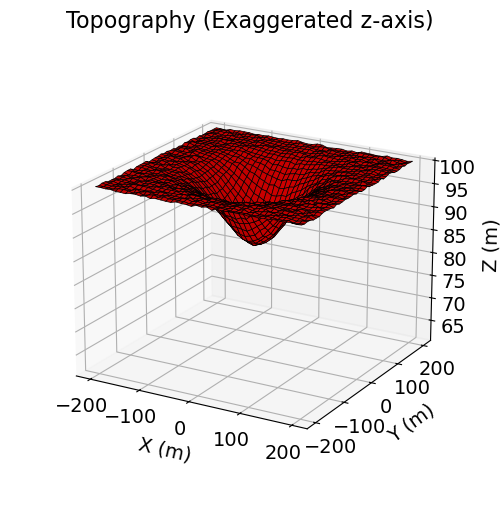

In [3]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection="3d")
ax.set_zlim([z_topo.max() - 40, z_topo.max()])
ax.plot_surface(x_topo, y_topo, z_topo, color="r", edgecolor="k", linewidth=0.5)
ax.set_box_aspect(aspect=None, zoom=0.85)
ax.set_xlabel("X (m)", labelpad=10)
ax.set_ylabel("Y (m)", labelpad=10)
ax.set_zlabel("Z (m)", labelpad=10)
ax.set_title("Topography (Exaggerated z-axis)", fontsize=16, pad=-20)
ax.view_init(elev=20.0)

In [4]:
x_topo, y_topo, z_topo = mkvc(x_topo), mkvc(y_topo), mkvc(z_topo)
topo_xyz = np.c_[x_topo, y_topo, z_topo]

## Define the Survey

Surveys within SimPEG generally require the user to create and connect three types of objects:

- [receivers](myst:simpeg#simpeg.potential_fields.magnetics.receivers.Point): which define the locations of field measurements and type of data being measured.
- [sources](myst:simpeg#simpeg.potential_fields.magnetics.sources.UniformBackgroundField): the passive or active sources responsible for generating geophysical responses, and their associated receivers.
- [survey](myst:simpeg#simpeg.potential_fields.magnetics.Survey): the object which stores and organizes all of the sources and receivers.

Here, we define the survey that will be used for the forward simulation. Magnetic surveys are simple to create. The user only needs an (N, 3) [numpy.ndarray](myst:numpy#numpy.ndarray) to define the xyz locations of the observation locations, the field components being measured, and the Earth's inducing field. For the tutorial simulation, the receivers are located 10 m above the surface topography and spaced 10 m apart.

In [5]:
# Define the observation locations as an (N, 3) numpy array or load them.
x = np.linspace(-80.0, 80.0, 17)
y = np.linspace(-80.0, 80.0, 17)
x, y = np.meshgrid(x, y)
x, y = mkvc(x.T), mkvc(y.T)
fun_interp = LinearNDInterpolator(np.c_[x_topo, y_topo], z_topo)
z = fun_interp(np.c_[x, y]) + 10  # Flight height 10 m above surface.
receiver_locations = np.c_[x, y, z]

In [6]:
# Define the component(s) of the field we want to simulate as a list of strings.
# Here we simulation total magnetic intensity data.
components = ["tmi"]

# Use the observation locations and components to define the receivers. To
# simulate data, the receivers must be defined as a list.
receiver_list = magnetics.receivers.Point(receiver_locations, components=components)
receiver_list = [receiver_list]

# Define the inducing field
inclination = 90   # inclination [deg]
declination = 0    # declination [deg]
amplitude = 50000  # amplitude [nT]

source_field = magnetics.sources.UniformBackgroundField(
    receiver_list=receiver_list,
    amplitude=amplitude,
    inclination=inclination,
    declination=declination
)

# Define the survey
survey = magnetics.survey.Survey(source_field)

If desired, we can extract various objects and properties from the objects used to generate the survey. E.g.

In [7]:
print("# of data: {}".format(survey.nD))  # number of data that will be simulated
print(survey.source_field.inclination)  # inclination of the source field
print(survey.source_field.receiver_list[0])  # the receiver object
print(receiver_list[0].locations[:5, :])  # the first 5 receiver locations

# of data: 289
90.0
[[-80.         -80.         108.32489288]
 [-70.         -80.         107.79049884]
 [-60.         -80.         107.23257535]
 [-50.         -80.         106.50517416]
 [-40.         -80.         105.85063789]]


## Design a (Tensor) Mesh

Meshes are designed using the [discretize](https://discretize.simpeg.xyz/en/main) package. See the [discretize user tutorials](https://discretize.simpeg.xyz/en/main/tutorials/mesh_generation/index.html) to learn more about creating meshes.
Here, the forward simulation is computed for a [tensor mesh](myst:discretize#discretize.TensorMesh). If you wanted to generate a [tree mesh](myst:discretize#discretize.TreeMesh) instead, you can use the code snippet from the [Forward simulation of magnetic gradiometry data](fwd_magnetics_gradiometry_3d.ipynb) tutorial.

The integral formulation for magnetics essentially sums the independent contribution for every magnetized voxel cell in the mesh. Since the kernel function that computes the contribution for a single cell is an analytic solution, small cells are not required to accurately compute the contributions from coarse structures with constant magnetization (e.g. a rectangular prism). For complex structures however, or to define surface topography more accurately, finer cells may be needed. Furthermore, cells do not need to be cubic. **Since the analytic solution is only valid outside the magnetized region, please do no place receivers within the Earth.**

Here, a core cell width of 5 m is used within our survey region. Padding is used to extend the mesh outside the immediate survey area. The mesh will be plotted after we define our density contrast model.

In [8]:
# Generate tensor mesh with top at z = 0 m
dh = 5.0
hx = [(dh, 5, -1.3), (dh, 40), (dh, 5, 1.3)]
hy = [(dh, 5, -1.3), (dh, 40), (dh, 5, 1.3)]
hz = [(dh, 5, -1.3), (dh, 15)]
mesh = TensorMesh([hx, hy, hz], "CCN")

# Shift vertically to top same as maximum topography
mesh.origin += np.r_[0.0, 0.0, z_topo.max()]

If desired, we can extract various properties of the mesh. E.g.

In [9]:
print("# of cells: {}".format(mesh.n_cells))  # Number of cells
print("# of x-faces: {}".format(mesh.n_faces_x))  # Number of x-faces
print("Origin: {}".format(mesh.origin))  # bottom-southewest corner
print("Max cell volume: {}".format(mesh.cell_volumes.max()))  # Largest cell size
print(mesh.cell_centers[0:5, :])  # Cell center locations

# of cells: 50000
# of x-faces: 51000
Origin: [-158.78015    -158.78015     -33.28376894]
Max cell volume: 6398.236626761349
[[-149.497825   -149.497825    -24.00144394]
 [-133.07525    -149.497825    -24.00144394]
 [-120.4425     -149.497825    -24.00144394]
 [-110.725      -149.497825    -24.00144394]
 [-103.25       -149.497825    -24.00144394]]


## Define the Active Cells

Whereas cells below the Earth's surface contribute towards the simulated magnetic anomaly, air cells do not. 
The set of mesh cells used in the forward simulation are referred to as 'active cells'. Unused cells (air cells) are 'inactive cells'. Here, the discretize [active_from_xyz](myst:discretize#discretize.utils.active_from_xyz) utility function is used to find the indices of the active cells using the mesh and surface topography. The output quantity is a ``bool`` array.

In [10]:
# Indices of the active mesh cells from topography (e.g. cells below surface)
active_cells = active_from_xyz(mesh, topo_xyz)

## Mapping from the Model to Active Cells

In SimPEG, the term 'model' is not synonymous with the physical property values defined on the mesh. For example, the model may be defined as the logarithms of the physical property values, or be parameters defining a layered Earth. When simulating total magnetic intensity data using the integral formulation, we must define a mapping from the set of model parameters to the active cells in the mesh. Mappings are created using the [simpeg.maps](myst:simpeg#simpeg.maps.IdentityMap) module. For the tutorial exercise, the model is the susceptibility values for all active cells. As such, our mapping is an identity mapping, whose dimensions are equal to the number of active cells.

In [11]:
# Define mapping from model to active cells. The model consists of a
# susceptibility value for each cell below the Earth's surface.
n_active = int(active_cells.sum())
model_map = maps.IdentityMap(nP=n_active)

## Define the Model

Here, we create the model that will be used to predict total magnetic intensity data.
Recall that our model is the susceptibility values for all active mesh cells.
So the model is a 1D [numpy.ndarray](myst:numpy#numpy.ndarray) whose length is
equal to the number of model parameters.
**In SimPEG, susceptibility values are in SI units**.
Here, the model consists of a susceptible sphere within a negligibly susceptible host.
We plot the model using the [plot_slice](myst:discretize#discretize.TensorMesh.plot_slice) method.

In [12]:
# Define susceptibility values for each unit in SI
background_susceptibility = 0.0001
sphere_susceptibility = 0.01

In [13]:
# Instantiate a vector array. Models in SimPEG are vector arrays.
model = background_susceptibility * np.ones(n_active)

# You can use SimPEG utilities to add structures to the model more concisely,
# or index the mesh cells manually.
ind_sphere = model_builder.get_indices_sphere(
    np.r_[0.0, 0.0, 55.0], 16.0, mesh.cell_centers
)
ind_sphere = ind_sphere[active_cells]
model[ind_sphere] = sphere_susceptibility

In [14]:
# Mapping to ignore inactive cells when plotting model
plotting_map = maps.InjectActiveCells(mesh, active_cells, np.nan)

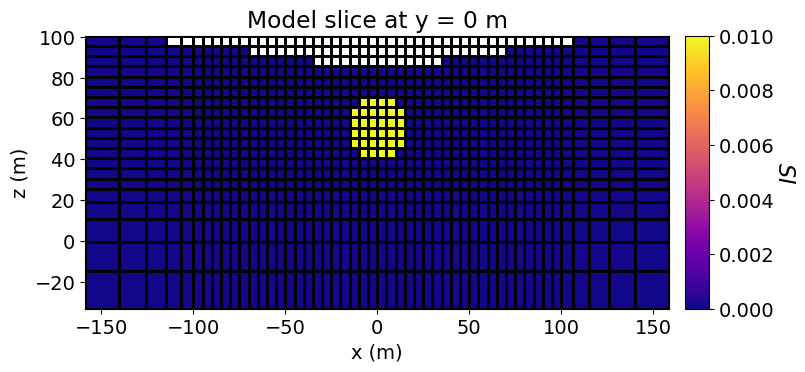

In [15]:
# Plot Susceptibility Model
fig = plt.figure(figsize=(8, 3.5))
ax1 = fig.add_axes([0.1, 0.12, 0.73, 0.78])

norm = mpl.colors.Normalize(vmin=0, vmax=np.max(model))
mesh.plot_slice(
    plotting_map * model,
    normal="Y",
    ax=ax1,
    ind=int(mesh.shape_cells[1] / 2),
    grid=True,
    pcolor_opts={"cmap": mpl.cm.plasma, "norm": norm},
)
ax1.set_title("Model slice at y = 0 m")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.85, 0.12, 0.03, 0.78])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.plasma
)
cbar.set_label("$SI$", rotation=270, labelpad=15, size=16)

plt.show()

## Define the Forward Simulation

In SimPEG, the physics of the forward simulation is defined by creating an instance of an appropriate simulation class.
In this case, we use the simulation class for the [3D integral formulation](myst:simpeg#simpeg.potential_fields.magnetics.Simulation3DIntegral). To fully define the forward simulation, we need to connect the simulation object to:

- the survey
- the mesh
- the indices of the active cells
- the mapping from the model to the active cells
- the model type: "scalar" for susceptibility model, "vector" for magnetic vector model

This is accomplished by setting each one of the aforementioned items as a property of the simulation object. Additional keyword arguments can also be set which impact the forward simulation. Because we are only simulating data for a single model, there is no benefit to storing the sensitivities for the forward simulation. ``store_sensitivities`` property to *'forward_only'*

> By choosing `engine="choclo"` we can make our simulation to run the faster and more memory efficient implementation of the magnetic forward that uses [Numba](https://numba.pydata.org/) and [Choclo](https://www.fatiando.org/choclo) under the hood. To do so, we need to have [Choclo installed](https://www.fatiando.org/choclo/latest/install.html).

In [16]:
simulation = magnetics.simulation.Simulation3DIntegral(
    survey=survey,
    mesh=mesh,
    model_type="scalar",
    chiMap=model_map,
    ind_active=active_cells,
    store_sensitivities="forward_only",
    engine="choclo",
)

## Simulate Total Magnetic Intensity Data

Once any simulation within SimPEG has been properly constructed, simulated data for a given model vector can be computed using the [dpred](myst:simpeg#simpeg.simulation.BaseSimulation.dpred) method. In SimPEG, total magnetic data values are in **units nT.**

In [17]:
dpred = simulation.dpred(model)

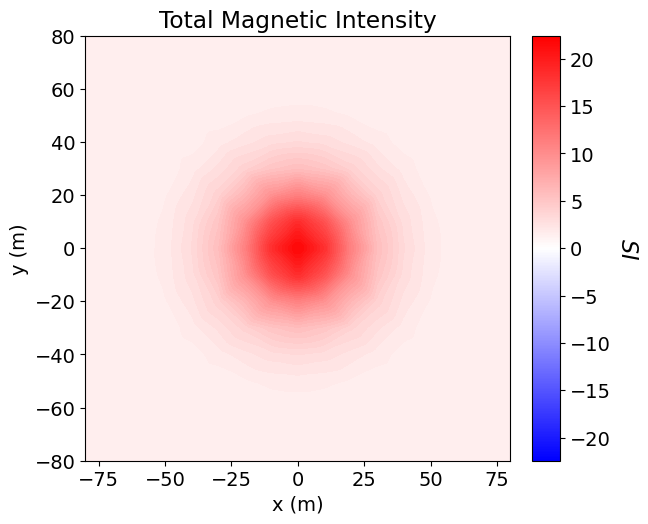

In [18]:
fig = plt.figure(figsize=(7, 5))
ax1 = fig.add_axes([0.1, 0.1, 0.75, 0.85])

norm = mpl.colors.Normalize(vmin=-np.max(np.abs(dpred)), vmax=np.max(np.abs(dpred)))
plot2Ddata(
    receiver_list[0].locations,
    dpred,
    ax=ax1,
    ncontour=40,
    contourOpts={"cmap": mpl.cm.bwr, "norm": norm},
)
ax1.set_title("Total Magnetic Intensity")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.81, 0.1, 0.04, 0.85])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr
)
cbar.set_label("$SI$", rotation=270, labelpad=20, size=16)

plt.show()

**Optional:** Export the data and topography

In [19]:
if save_output:
    dir_path = os.path.sep.join([".", "fwd_magnetics_induced_3d_outputs"]) + os.path.sep
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)

    fname = dir_path + "magnetics_topo.txt"
    np.savetxt(fname, np.c_[topo_xyz], fmt="%.4e")

    np.random.seed(211)
    maximum_anomaly = np.max(np.abs(dpred))
    noise = 0.02 * maximum_anomaly * np.random.normal(size=len(dpred))
    fname = dir_path + "magnetics_data.obs"
    np.savetxt(fname, np.c_[receiver_locations, dpred + noise], fmt="%.4e")